- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [1]:
import sys
print(sys.executable)

c:\Users\mayeu\.venvs\venvPFE\Scripts\python.exe


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cpu
None
False


In [4]:
import numpy as np
import pandas as pd
import gcsfs
import xarray as xr
import scipy

## Generate datas

First we need to generate the data by simplifying the era5 grid with the corresponding keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For all key, we will generate data based on the density of these 5 pressure levels ([0, 10, 20, 30, 36]).

In [5]:
input_variables =['geopotential', 
                    'specific_humidity','temperature',
                    'u_component_of_wind',
                    'v_component_of_wind',
                    'specific_cloud_ice_water_content',
                    'specific_cloud_liquid_water_content']

forcing_variables = ['sea_ice_cover', 'sea_surface_temperature']

longitude_nodes=64
latitude_nodes=32

longitude_nodes_original = 256
latitude_nodes_original = 128
level_original = [i for i in range(37)]
level = [0, 10, 20, 30, 36]
dtime = '2020-02-14T00'

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-18'
data_inner_steps = 6

path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

In [6]:
gcs = gcsfs.GCSFileSystem(token='anon')
full_era5 = xr.open_zarr(gcs.get_mapper(path), chunks=None)

In [7]:
full_era5

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2025-02-08 09:25:59.279575
    valid_time_stop:   2024-11-30

In [ ]:
from import_era5 import data_generation

regridded, sliced_era5 = data_generation(data = full_era5,
    demo_start_time = '2020-01-01',
    demo_end_time = '2020-02-01',
    data_inner_steps = data_inner_steps, 
    input_variables = input_variables,
    forcing_variables = forcing_variables,
    longitude_nodes = longitude_nodes,
    latitude_nodes = latitude_nodes,
    level = level)

In [ ]:
dtime = '2020-02-14T00'
sliced_dtime_era5 = sliced_era5.sel(time=dtime).compute()
regridded_dtime = regridded.sel(time=dtime).compute()

sliced_dtime_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded_dtime.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

### Normalization of input features

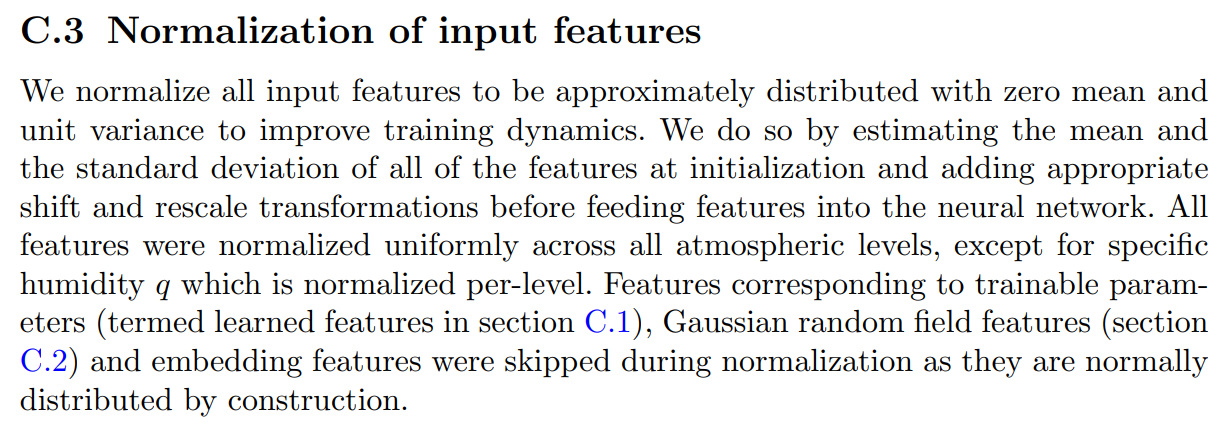

First of all, we normalise the data in order to obtain reduced centred data. And we do so for all the other features. The normalised data is then transferred to encoder (Lounis)

In [ ]:
def normalize_z_score(array):
    mean_val = array.mean(dim=array.dims)
    std_val = array.std(dim=array.dims)
    return (array - mean_val) / std_val

In [ ]:
normalized_dataset = regridded.copy()

for var in regridded.data_vars:
    dims = regridded[var].dims
    normalized_dataset[var] = normalize_z_score(regridded[var])